# Model Evaluation and Validation

## Model Evaluation: Classifiers

- Accuracy
- Precision
- Recall
- Log-Loss

## Balancing under- and over-fitting: cross-validation

# Classifier Evaluation: Accuracy

## Accuracy = (# correct predictions) / (total # of predictions)

"% correct"

Decent to train classifiers on, but some nuance is missing

# Classifier Evaluation: Precision and Recall

![Precision Recall](../data/img/Precisionrecall.svg)

By Walber - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=36926283

# Scoring probabilities: log-loss

The sum of:

- the log of the probability we assigned to the correct class
- the log of (1-the probability we assigned to the incorrect class(es))

In [1]:
import numpy as np
from sklearn.metrics import log_loss

In [2]:
probs = np.r_[0:1:50j]
prob_predictions = np.c_[probs, 1.0 - probs]

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
log_loss_values = [
    log_loss([0], [prob], labels=[0, 1])
    for prob in prob_predictions
]

Text(0.5, 0, 'P(y=0)')

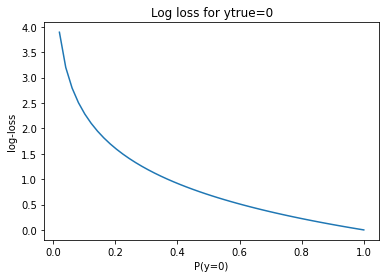

In [5]:
plt.plot(probs[1:], log_loss_values[1:])
plt.title('Log loss for ytrue=0')
plt.ylabel('log-loss')
plt.xlabel('P(y=0)')

# Types of errors, validation, model tuning

## High Bias = Underfitting

Our model is not flexible enough to capture underlying reality, e.g. using a linear model for a nonlinear reality.

In this case, we observe that our *training* error is high (and our test error will also be high).

## High Variance = Overfitting

In this case, we've fit too closely to the particular training data we chose, and small variations in our data may lead to wildly different results. 

In this case, we observe that while our *training* error may be low, our *test* error is high (and can vary a lot based on how we split test and train data).

## Using Cross-Validation to limit overfitting

In this case, we actually perform *two* splits of our input data:

1. First, we sample some of the data and set it aside as our *test* dataset (and don't peek!)
1. Next, we split the *remaining* data into a training set and a validation set. We then *train* the model on the training set and *evaluate* it on the validation set.
1. Repeat the previous step a number of times with different training/validation splits to verify that we aren't over-fitting

## Cross-validation approaches: K-fold

Split the data into k groups. Use each group once as the validation set, training on the rest

In [6]:
import pandas as pd

train = pd.read_csv('../data/sfcrime-hackathon/hackathon_train.csv')
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2011-12-04 18:15:00,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,Sunday,PARK,NONE,100 Block of BEULAH ST,-122.452331,37.767356
1,2009-01-11 19:57:00,WARRANTS,ENROUTE TO OUTSIDE JURISDICTION,Sunday,MISSION,"ARREST, BOOKED",18TH ST / CAPP ST,-122.418272,37.761903
2,2007-01-25 18:15:00,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Thursday,CENTRAL,NONE,1200 Block of STOCKTON ST,-122.408521,37.797492
3,2012-01-10 08:55:00,ROBBERY,"ROBBERY, BODILY FORCE",Tuesday,NORTHERN,NONE,HAYES ST / FRANKLIN ST,-122.421333,37.777090
4,2014-05-27 12:25:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,TENDERLOIN,NONE,JONES ST / TURK ST,-122.412414,37.783004


In [7]:
from sklearn import preprocessing
from sklearn import model_selection

cv = model_selection.KFold(n_splits=5, shuffle=True)

In [8]:
for train_idx, val_idx in cv.split(train):
    print(train_idx.shape, val_idx.shape)

(526828,) (131708,)
(526829,) (131707,)
(526829,) (131707,)
(526829,) (131707,)
(526829,) (131707,)


Let's pick a simple model (and sample down our data) so we can see how this works with cross validation:

In [9]:
enc = preprocessing.LabelEncoder()

In [10]:
strain = train.sample(10_000)
X = pd.get_dummies(
    strain['DayOfWeek PdDistrict X Y'.split()],
    columns='DayOfWeek PdDistrict'.split()
)
y = enc.fit_transform(strain.Category)
                   

In [11]:
X.head()

,X,Y,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN
382749,-122.432311,37.768377,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
160747,-122.431958,37.764936,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
172731,-122.408068,37.783992,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
320366,-122.403405,37.775421,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
267344,-122.378574,37.730320,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0


In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
est = LogisticRegression(
    solver='liblinear',
    multi_class='auto',
)

Now we can cross-validate the estimator:

In [14]:
model_selection.cross_validate(est, X, y, cv=cv) # , return_train_score=False)

{'fit_time': array([3.78397632, 3.01351404, 2.05431318, 1.88927579, 1.6815598 ]),
 'score_time': array([0.09080195, 0.0132761 , 0.01338005, 0.01288104, 0.00992703]),
 'test_score': array([0.2245, 0.215 , 0.2175, 0.218 , 0.211 ])}

## Cross-validation approaches: stratified K-Fold

Ensure that we have proportional representation of output classes


In [15]:
cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True)
model_selection.cross_validate(est, X, y, cv=cv, return_train_score=False)

/Users/rick446/.virtualenvs/py38/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'fit_time': array([3.83699512, 3.14900517, 3.35553789, 2.90980816, 3.16658878]),
 'score_time': array([0.02160096, 0.03765297, 0.02555108, 0.03229809, 0.02075911]),
 'test_score': array([0.226 , 0.2135, 0.2165, 0.22  , 0.2145])}

## Cross-validation approaches: leave-one-out

Use a single point as our validation set. Repeat for all input points.

In [16]:
# First, sample our data even more because LOO is really compute-intensive

strain = train.sample(1000)
X = pd.get_dummies(
    strain['DayOfWeek PdDistrict X Y'.split()],
    columns='DayOfWeek PdDistrict'.split()
)
y = enc.fit_transform(strain.Category)
                   

In [17]:
cv = model_selection.LeaveOneOut()
result = model_selection.cross_validate(est, X, y, cv=cv, return_train_score=False)
result['test_score'].mean(), result['test_score'].std()

(0.176, 0.380820167533181)